# Genetic algorithm search for perovskites for water splitting

We will use a genetic algorithm (GA) to predict the best perovskite for water splitting.

## Background

[Castelli et al](http://xlink.rsc.org/?DOI=c2ee22341d) performed DFT screening of ~19000 perovskite materials. Only a small number of the calculated candidate materials (~20) were found to be sufficiently interesting to warrant further experimental investigation. A genetic algorithm could reduce the number of calculations required to locate the interesting candidates. We will try to make 19000 into ?

![split-water](images/split-water.png)

The data is publicly [available](https://cmr.fysik.dtu.dk/cubic_perovskites/cubic_perovskites.html#cubic-perovskites), so we can test how few candidates we can get away with calculating for discovering the best candidates. This assignment is similar to that performed by [Jain et al.](http://link.springer.com/10.1007/s10853-013-7448-9). Note we will use the database to look up the results of the calculations, we do not do any DFT calculations in this exercise. It is only a matter of trying to run and optimize the GA.

Start by downloading the database

In [1]:
!wget https://cmr.fysik.dtu.dk/_downloads/cubic_perovskites.db

--2018-10-31 09:07:50--  https://cmr.fysik.dtu.dk/_downloads/cubic_perovskites.db
Resolving cmr.fysik.dtu.dk... 130.225.86.24, 2001:878:200:2010:3::24
Connecting to cmr.fysik.dtu.dk|130.225.86.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47226880 (45M) [text/plain]
Saving to: `cubic_perovskites.db'

100%[======================================>] 47,226,880  84.0M/s   in 0.5s    

2018-10-31 09:07:51 (84.0 MB/s) - `cubic_perovskites.db' saved [47226880/47226880]



## Introduction to the database
We will try and browse through the data a bit to get a feel for what is inside the database. It contains some calculated properties of cubic perovskites, we will use it as a reference when we try to identify the best perovskite for water splitting. Along with the perovskite compounds, the database also contains reference calculations of the elements in their standard states. We start by connecting to the database (more info on the `ase db` module can be found [here]( https://wiki.fysik.dtu.dk/ase/ase/db/db.html#module-ase.db)), and inspecting a single row:

In [2]:
from ase.db import connect
db = connect('cubic_perovskites.db')
row = next(db.select())
#vars(row)

Each row of the database has some key-value pairs, which are stored explicitly, as well as some basic information which is always stored, recording how the data was calculated. Below are some values that we will have use for in this exercise.

- heat_of_formation_all
- gllbsc_dir_gap
- gllbsc_ind_gap
- CB_ind, CB_dir
- VB_ind, VB_dir


Each row also has a `toatoms()` method, which lets us extract an ase atoms object from the row.

In [4]:
from ase.visualize import view
view(row.toatoms())

When doing any kind of data analysis, the first step is always to become familiar with the data in question, on a basic level. The `select()` method of the database applies a query to the database and returns an iterator of all the rows matching that query. To select all rows with a user of `einstein`, we would type `db.select(user='einstein')`. To select all rows with a gllbsc direct gap greater than 0.5 eV, we would type `db.select('gllbsc_dir_gap>0.5')`.
Counting the number of hits can be be done using `db.count(key=value)` for some key-value pair.

How many rows are there in the database? 


In [11]:
db.select('gllbsc_dir_gap>1.7')

<generator object Database.select at 0x7fdfa7b9edb0>

In [14]:
db.count(key='gllbsc_dir_gap>1.7')

0

The structures in the database were generated from the general formula ABX, and then varying A, B and X. X represents the anions.

The A, B and X is encoded in values of the keys `A_ion`, `B_ion` and `anion` respectively, i.e. `row.A_ion -> 'Ti'`.

1. Try to identify the A, B and X elements that was used for the study.
2. By making all possible combinations of both A, B, X, how many structures could be generated in total? (A = B are allowed)
3. Make two lists called `AB_ions` and `anions` respectively that holds the possibilities for `A`, `B` and `X`. It will be needed to run the GA.

In [3]:
A_ions, B_ions, anions = set(), set(), set()
temp = set()
for dct in db.select('anion'):
    A_ions.add(dct.A_ion)
    B_ions.add(dct.B_ion)
    anions.add(dct.anion)
AB_ions = list(A_ions)
anions = list(anions)
print(len(AB_ions)*len(AB_ions)*len(anions))

18928


The structures in the database were generated from the general formula ABX, and then varying A, B and X. X represents the anions.

The A, B and X is encoded in values of the keys `A_ion`, `B_ion` and `anion` respectively, i.e. `row.A_ion -> 'Ti'`.

1. Try to identify the A, B and X elements that was used for the study.
2. By making all possible combinations of both A, B, X, how many structures could be generated in total? (A = B are allowed)
3. Make two lists called `AB_ions` and `anions` respectively that holds the possibilities for `A`, `B` and `X`. It will be needed to run the GA.

Taking into account modern day computer power the number of possible candidates does not refrain us from doing a full screening of all combinations. If the number was one or two orders of magnitude higher (easily imagineably by adding more anions or a different class of A/B ions i.e. organic molecules) a full screening would not be feasible. The GA is a good method to use for an optimization problem with a large phase space.

## About genetic algorithms

A GA takes a Darwinistic approach to optimization by maintaining a *population* of solution *candidates* to a problem (e.g.\ what is the best perovskite for water splitting). The population is evolved to obtain better solutions by mating and mutating selected candidates and putting the fittest *offspring* in the population. The *fitness* of a candidate is a function which, for example, measures the stability or performance of a candidate. Natural selection is used to keep a constant population size by removing the least fit candidates. Mating or *crossover* combine candidates to create offspring with parts from more candidates present, when favorable traits are combined and passed on the population is evolved. Only performing crossover operations risks stagnating the evolution due to a lack of diversity -- performing crossover on very similar candidates is unlikely to create progress when performed repeatedly. *Mutation* induces diversity in the population and thus prevents premature convergence. The figure below gives a simplified outline of the algorithm.

![ga-outline](images/ga-outline.png)

GAs are generally applicable to areas where traditional optimization by derivative methods are unsuited and a brute force approach is computationally infeasible.

Furthermore, the output of a GA run will be a selection of optimized candidates, which often will be preferred over only getting the best candidate, especially taking into account the potential inaccuracy of the employed methods. Thus a GA finds many applications within atomic simulations, and will often be one of the best methods for searching large phase spaces.



## Start the GA

We will start by putting the reference database into local memory. This makes lookup of values of each candidate much faster. Then we will set up another database that will hold the candidates generated by the GA.

In [138]:
def build_ref_dict(ref_db):
    dct = {}
    for row in ref_db.select('anion'):
        # Use a key: A-B-X to look up each row
        s = '-'.join([row.A_ion, row.B_ion, row.anion])
        dct[s] = row
    return dct

# The reference database are put in local memory for faster lookup
ref_dict = build_ref_dict(db)
print('built ref dictionary')


built ref dictionary


The variables below are needed to initialize the GA

In [141]:
# File nam
!rm ga_water_splitters.db
ga_db_file = 'ga_water_splitters.db'

# Define the population size
pop_size = 50

# Phase space should be defined in AB_ions and anions
# These variables should be lists

Here we initialize the database file that holds information about the GA run.

In [142]:
from ase.ga.data import PrepareDB

# Initialize the GA database
prep_ga_db = PrepareDB(ga_db_file,
                       population_size=pop_size,
                       anions=anions, AB_ions=AB_ions)

Now we create the initial population by creating random candidates.

In [143]:
import random

# Construct a random starting population
print('Generating random population of size {0}'.format(pop_size))
start_set = set()
for _ in range(pop_size):
    # Choose two random from AB_ions and one random from anions
    cand = random.sample(AB_ions, 2) + random.sample(anions, 1)
    s = '-'.join(cand)
    # We don't want duplicates in the starting population
    if s in start_set:
        continue
    start_set.add(s)
    # A candidate is added to the database, it is not evaluated (unrelaxed)
    prep_ga_db.add_unrelaxed_candidate(ref_dict[s].toatoms(),
                                       atoms_string=s)
print('Done.')


Generating random population of size 50
Done.


Now the initialization of the database file is finished. You can move on to [Run the GA](#Run-the-GA)

Run the cell below if *and only if* you need to restart the algorithm. It will delete all the progress in the database file.

In [133]:
import os
if os.path.isfile(ga_db_file):
    os.remove(ga_db_file)

## Run the GA

First we need to use a different class for the database.

In [144]:
from ase.ga.data import DataConnection

ga_db = DataConnection(ga_db_file)


Then we will evaluate the starting population. Each candidate is evaluated based on stability (heat of formation), band gap and maximum of valence and minimum of conduction band, they should be positioned at the O2/H2O and H+/H2 potentials respectively. The evaluation of each candidate ends with an assigment of a raw score. The raw score help to determine how fit each candidate is when comparing to the rest of the population. For more information see the function `get_raw_score` in the file ga_help.py

In [145]:
from ga_help import evaluate, get_evaluated_set

# Evaluate the starting population
candidates_to_be_added = []
for a in ga_db.get_all_unrelaxed_candidates():
    evaluate(a, ref_dict)
    candidates_to_be_added.append(a)
ga_db.add_more_relaxed_candidates(candidates_to_be_added)

# Keep track of the candidates that has been evaluated
already_evaluated = get_evaluated_set(ga_db_file)


The algorithm works by maintaining a population of candidates, that is evolved towards the optimal candidates as the algorithm run progresses. Below we initialize the population class.

In [146]:
from ase.ga.standard_comparators import StringComparator
from ase.ga.population import Population

# Define how to compare two different candidates
comp = StringComparator('atoms_string')

# The population is kept in the Population instance
pop = Population(data_connection=ga_db,
                 population_size=pop_size,
                 comparator=comp)


![perovskite](images/perovskite.png)

Each candidate is represented by a list of elements `[A, B, X]`. The algorithm will evolve the population not unlike natural evolution by combining and mutating the best candidates in the population to create new candidates better adjusted to fit the environment.

Evolution takes place through operators, that are defined as individual classes:
- `OnePointListCrossover`
- `RandomListMutation`
- `NeighborhoodListMutation`
- `ListPermutation`
- `RandomListCreation`

Try and see how each operator works. See below for examples

In [147]:
from list_operators import RandomListMutation
from ga_help import get_atoms_string

# Two candidates are selected from the population as parents
a1, a2 = pop.get_two_candidates(with_history=False)

print(get_atoms_string(a1))

# Initialize an operator
random_operator = RandomListMutation([AB_ions, anions])

# Use the get_new_individual method to get a new candidate
# Two parents are accepted even though only one is returned
offspring, desc = random_operator.get_new_individual([a1, a2])
print(desc)
print(get_atoms_string(offspring))

Sb-W-O3
RandomListMutation: Parent 67
Ni-W-O3


In [148]:
from list_operators import OnePointListCrossover

# Get two candidates from the population
a1, a2 = pop.get_two_candidates(with_history=False)

print(get_atoms_string(a1), get_atoms_string(a2))

# Initialize an operator
crossover_operator = OnePointListCrossover()

# The crossover takes two candidates as input and combine to produce offspring
offspring, desc = crossover_operator.get_new_individual([a1, a2])
print(desc)
print(get_atoms_string(offspring))

Cs-Te-O3 Ba-Sr-O3
OnePointListCrossover: Parents 51 75
Cs-Sr-O3


Now we put all the available operators together with probabilities of how often they are selected to produce new candidates.

In [149]:
from ase.ga.offspring_creator import OperationSelector
from list_operators import OnePointListCrossover, RandomListMutation,\
    NeighborhoodListMutation, ListPermutation, RandomListCreation

# Specify the procreation operators for the algorithm
# Try and play with the mutation operators that move to nearby
# places in the periodic table
oclist = ([1, 3, 1, 1, 1], [RandomListMutation([AB_ions, anions]),
                            OnePointListCrossover(),
                            NeighborhoodListMutation([AB_ions, anions]),
                            RandomListCreation([AB_ions, anions], [2, 1]),
                            ListPermutation([AB_ions, anions])])
operation_selector = OperationSelector(*oclist)

Now we write the loop that in essence is the algorithm. Try and run the cell below a couple of times and see that fitter candidates are produced as the population evolves. Then go to the [Analysis](#analysis) section to check how the GA is performing and then come back here and run it some more.

In [150]:
from ga_help import set_syms

print('Number of evaluated candidates in database: {0}'.format(len(already_evaluated)))
worst_raw_score_in_pop = pop.pop[-1].info['key_value_pairs']['raw_score']
# Get the largest gaid in db
max_id = ga_db.get_largest_in_db('gaid')

# This many candidates will be tested in this loop
num_cands = 500

# Run the algorithm
add_later = []
for i in range(1, num_cands + 1):
    offspring = None
    while offspring is None or s in already_evaluated:
        # Select parents
        a1, a2 = pop.get_two_candidates(with_history=False)
        
        # Select procreation operator
        op = operation_selector.get_operator()
        
        # Do the operation
        offspring = op.get_new_individual([a1, a2])
        
        # Get the candidate as a string to check if it has already
        # been evaluated
        s = get_atoms_string(offspring)

    # Technical details not important
    a3, desc = offspring
    set_syms(a3, ref_dict[s])
    already_evaluated.add(s)
    # We don't save the unrelaxed candidates in this case, due to speed
    # So we have to set an artificial confid
    # db.add_unrelaxed_candidate(a3, description=desc)
    a3.info['confid'] = i + max_id

    # Invoke the evaluation
    evaluate(a3, ref_dict)

    # If the evaluated candidate will enter the population it will be saved
    # now, else it is written after the loop terminates
    if a3.info['key_value_pairs']['raw_score'] > worst_raw_score_in_pop:
        ga_db.add_relaxed_step(a3)

        pop.update()
        worst_raw_score_in_pop = pop.pop[-1].info['key_value_pairs']['raw_score']
    else:
        add_later.append(a3)

    # Print the progress of the algorithm for every 200 evaluated candidates
    if i % 200 == 0:
        best = pop.pop[0].info['key_value_pairs']
        worst = pop.pop[-1].info['key_value_pairs']
        print('After {0} evaluations'.format(i))
        print('Best candidate in population:', best['atoms_string'],
              best['raw_score'])
        print('Worst candidate in population:', worst['atoms_string'],
              worst['raw_score'])
        print(50 * '-')

print('Writing rest of candidates to database (#{0})'.format(len(add_later)))
ga_db.add_more_relaxed_candidates(add_later)

Number of evaluated candidates in database: 49


IndexError: Cannot choose from an empty sequence

## Analysis

Since all the candidates have previously been calculated we can evaluate the effectiveness of the algorithm. How quickly it discovers the top candidates compared to a random search.

![top-candidates](images/candidates.png)

First we need to get the raw score of all candidates

In [129]:
from ga_help import get_raw_score
from ase.db import connect
from operator import itemgetter

def generate_top_list(fname):
    ref_db = connect('cubic_perovskites.db')
    all_list = []
    for row in ref_db.select('anion'):
        s = '-'.join([row.A_ion, row.B_ion, row.anion])
        all_list.append((s, get_raw_score(row, method='product')))

    fd = open(fname, 'w')
    # sort the list by the raw score
    all_list.sort(key=itemgetter(1), reverse=True)
    for st, rs in all_list:
        print(st, rs, file=fd)
    fd.close()

generate_top_list('top_list.txt')


In [130]:
# Print out the top 20 candidates and their raw score
!head -20 top_list.txt

Ca-Nb-O2N 200.0
Ba-Ta-O2N 200.0
Sr-Ta-O2N 200.0
La-Ti-O2N 200.0
Ca-Ta-O2N 200.0
Sr-Nb-O2N 200.0
La-Ta-ON2 200.0
Ag-Ti-O2F 200.0
Sr-Sn-O3 200.0
Ba-Sn-O3 200.0
Sn-Ti-O3 200.0
Na-V-O3 199.53135739731692
Ga-Ta-O3 198.08459850688277
La-Nb-ON2 195.2477506800463
Y-Ta-ON2 192.15788783046463
Ba-Ga-O2F 192.15788783046463
Ba-Nb-O2N 190.9875718040057
Ca-Sn-O3 188.35290671684973
Sr-Ge-O3 188.35290671684973
Ca-Ge-O3 188.35290671684973


Now we can see how many of the top 20 is found by the current algorithm.

In [131]:
# Get the top list from the text file top_list.txt
f = open('top_list.txt')
top_list = []
for l in f:
    top_list.append(l.split(' ')[0])
f.close()

# Only consider the top 20
top_number = 20
top_list = top_list[:top_number]
    
db = connect(ga_db_file)
found = set()
i = 0
for row in db.select('relaxed=1', sort='gaid'):
    i += 1
    s = row.atoms_string
    if s in top_list and s not in found:
        found.add(s)
        lf = len(found)
        print(f'# found candidates in top {top_number}: {lf}. {s} evaluated as number: {i}')


# found candidates in top 20: 1. Ga-Ta-O3 evaluated as number: 10


Let us compare the performance with a random search. The cell below defines a function that returns the average number of draws it takes to find x number of top candidates [ref](https://math.stackexchange.com/questions/206798/pulling-cards-from-a-deck-without-replacement-to-reach-a-goal-average-draws-nee).

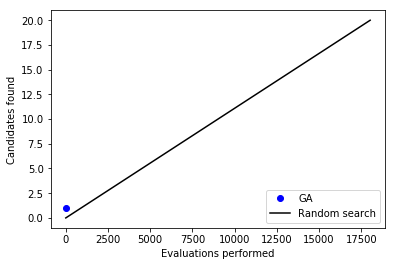

In [132]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from plot_help import remove_duplicate_labels

def random_search(number_of_candidates):
    search_space = 18928
    return (number_of_candidates * (search_space + 1)) / (top_number + 1)


# Plot the number of found candidates by GA as a function of evaluated candidates
found = set()
i = 0
for row in db.select('relaxed=1', sort='gaid'):
    i += 1
    s = row.atoms_string
    if s in top_list and s not in found:
        found.add(s)
        lf = len(found)
        plt.plot(i, lf, 'bo', label='GA')
        
# Plot the random search
y = np.array(range(top_number + 1))
plt.plot(random_search(y), y, 'k-', label='Random search')
plt.xlabel('Evaluations performed')
plt.ylabel('Candidates found')
remove_duplicate_labels(plt.gca())
plt.show()

## Assignment

Change the search space to only include oxides (`X=O3`) and do the same search locating the oxides best fitting for water splitting.